# VIX Trading Strategy: Rule-Based vs Machine Learning

### 1. Import Libraries and Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Plot style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("=== VIX-Based Trading Strategy: Rule-Based vs Machine Learning ===")
print("Libraries imported successfully!")

=== VIX-Based Trading Strategy: Rule-Based vs Machine Learning ===
Libraries imported successfully!


### 2. Load Data

Datasets used (downlaoded from Kaggle):
1. S&P 500 Historical Data [https://www.kaggle.com/datasets/henryhan117/sp-500-historical-data/code]
2. VIX Volatility Index Daily Price [https://www.kaggle.com/datasets/maxsmyc/vix-volatility-index-daily-price]

In [7]:
print("📊 Loading Kaggle datasets...")

#S&P 500 Data
sp500_data = pd.read_csv('../data/SPX.csv')
print(f"✅ S&P 500 data loaded: {len(sp500_data)} rows")
print("S&P 500 columns:", sp500_data.columns.tolist())
print("S&P 500 sample:")
print(sp500_data.head(3))

#VIX Data
vix_data = pd.read_csv('../data/VIX.csv')
print(f"✅ VIX data loaded: {len(vix_data)} rows")
print("VIX columns:", vix_data.columns.tolist())
print("VIX sample:")
print(vix_data.head(3))

📊 Loading Kaggle datasets...
✅ S&P 500 data loaded: 23323 rows
S&P 500 columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
S&P 500 sample:
         Date       Open       High        Low      Close  Adj Close  Volume
0  1927-12-30  17.660000  17.660000  17.660000  17.660000  17.660000       0
1  1928-01-03  17.760000  17.760000  17.760000  17.760000  17.760000       0
2  1928-01-04  17.719999  17.719999  17.719999  17.719999  17.719999       0
✅ VIX data loaded: 6318 rows
VIX columns: ['Date', 'Close', 'High', 'Low', 'Open']
VIX sample:
       Date      Close   High        Low       Open
0  1/3/2000  24.209999  26.15  23.980000  24.360001
1  1/4/2000  27.010000  27.18  24.799999  24.940001
2  1/5/2000  26.410000  29.00  25.850000  27.980000


### 3. Data Preprocessing

Date scope: 2000-02-01 to 2020-10-31

In [8]:
print("🔧 Preprocessing data...")

# Clean S&P 500 data
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])
sp500_data = sp500_data[(sp500_data['Date'] >= '2000-02-01') & (sp500_data['Date'] <= '2020-10-31')]
sp500_data = sp500_data.sort_values('Date')
sp500_data.set_index('Date', inplace=True)

# Use Adjusted Close for S&P 500
sp500_clean = sp500_data[['Adj Close']].copy()
sp500_clean.columns = ['SP500_Price']

# Clean VIX data
vix_data['Date'] = pd.to_datetime(vix_data['Date'])
vix_data = vix_data[(vix_data['Date'] >= '2000-02-01') & (vix_data['Date'] <= '2020-10-31')]
vix_data = vix_data.sort_values('Date')
vix_data.set_index('Date', inplace=True)

# Use Close price for VIX
vix_clean = vix_data[['Close']].copy()
vix_clean.columns = ['VIX']

# Merge datasets on date (the data that we will use)
data = pd.merge(sp500_clean, vix_clean, left_index=True, right_index=True, how='inner')

# Remove any remaining NaN values
data = data.dropna()

print(f"✅ Combined dataset: {len(data)} observations")
print(f"Date range: {data.index[0].date()} to {data.index[-1].date()}")
print("Combined data sample:")
print(data.head())
print(f"Data shape: {data.shape}")

🔧 Preprocessing data...
✅ Combined dataset: 5222 observations
Date range: 2000-02-01 to 2020-10-30
Combined data sample:
            SP500_Price        VIX
Date                              
2000-02-01  1409.280029  23.450001
2000-02-02  1409.119995  23.120001
2000-02-03  1424.969971  22.010000
2000-02-04  1424.369995  21.540001
2000-02-07  1424.239990  22.790001
Data shape: (5222, 2)


### 4. Feature Engineering

Features: VIX and market patterns, momentum, trends

In [9]:
def create_comprehensive_features(df):
    # Basic returns
    df['SP500_Return'] = df['SP500_Price'].pct_change()
    df['VIX_Return'] = df['VIX'].pct_change()
    
    # VIX Features - Core volatility signals
    df['VIX_MA10'] = df['VIX'].rolling(10).mean() # 2 weeks
    df['VIX_MA20'] = df['VIX'].rolling(20).mean() # 1 month
    df['VIX_MA50'] = df['VIX'].rolling(50).mean() # 10 weeks (1.5 months)
    
    # VIX percentile rankings (to decide high VIX threshold)
    df['VIX_Percentile_63'] = df['VIX'].rolling(63).rank(pct=True)   # Quarterly
    df['VIX_Percentile_252'] = df['VIX'].rolling(252).rank(pct=True) # Annual
    
    # VIX momentum and changes
    df['VIX_Change_1D'] = df['VIX'].pct_change(1) # 1 day
    df['VIX_Change_5D'] = df['VIX'].pct_change(5) # 1 week
    df['VIX_Change_10D'] = df['VIX'].pct_change(10) # 2 weeks
    
    # VIX relative to moving averages (to capture trends)
    df['VIX_MA10_Ratio'] = df['VIX'] / df['VIX_MA10'] # 2 weeks
    df['VIX_MA20_Ratio'] = df['VIX'] / df['VIX_MA20'] # 1 month
    
    # VIX spike detection
    df['VIX_Spike'] = (df['VIX'] / df['VIX_MA20'] > 1.3).astype(int)
    
    # S&P 500 Features - Market context
    df['SP500_MA20'] = df['SP500_Price'].rolling(20).mean() # 1 month
    df['SP500_MA50'] = df['SP500_Price'].rolling(50).mean() # 5 months
    df['SP500_MA200'] = df['SP500_Price'].rolling(200).mean() # 10 months
    
    # S&P 500 momentum
    df['SP500_Momentum_5D'] = df['SP500_Price'].pct_change(5) # 1 week
    df['SP500_Momentum_10D'] = df['SP500_Price'].pct_change(10) # 2 weeks
    df['SP500_Momentum_20D'] = df['SP500_Price'].pct_change(20) # 4 weeks
    
    # S&P 500 trend indicators
    df['SP500_Above_MA20'] = (df['SP500_Price'] > df['SP500_MA20']).astype(int)
    df['SP500_Above_MA50'] = (df['SP500_Price'] > df['SP500_MA50']).astype(int)
    df['SP500_Above_MA200'] = (df['SP500_Price'] > df['SP500_MA200']).astype(int)
    
    # Realized volatility calculation
    df['SP500_RealizedVol_20D'] = df['SP500_Return'].rolling(20).std() * np.sqrt(252)
    df['VIX_RV_Spread'] = df['VIX'] - df['SP500_RealizedVol_20D']
    
    # Market regime indicators
    df['High_Vol_Regime'] = (df['VIX_Percentile_252'] > 0.8).astype(int)
    df['Low_Vol_Regime'] = (df['VIX_Percentile_252'] < 0.2).astype(int)
    
    # Target variable: Next day return direction
    df['Next_Day_Positive'] = (df['SP500_Return'].shift(-1) > 0).astype(int)
    
    # Target variable: Next day return magnitude (for regression)
    df['Next_Day_Return'] = df['SP500_Return'].shift(-1)
    
    print("✅ Features created!")
    return df

print("Feature engineering function defined.")

Feature engineering function defined.


In [10]:
# Apply feature engineering
data = create_comprehensive_features(data)
data_clean = data.dropna()

print(f"Clean dataset: {len(data_clean)} observations")
print(f"Total columns: {len(data_clean.columns)}")
print("New feature columns:")
feature_cols = [col for col in data_clean.columns if col not in ['SP500_Price', 'VIX']]
print(feature_cols)

# Check data quality
print(f"\nData quality check:")
print(f"Missing values: {data_clean.isnull().sum().sum()}")
print(f"Date range: {data_clean.index[0].date()} to {data_clean.index[-1].date()}")

✅ Features created!
Clean dataset: 4970 observations
Total columns: 30
New feature columns:
['SP500_Return', 'VIX_Return', 'VIX_MA10', 'VIX_MA20', 'VIX_MA50', 'VIX_Percentile_63', 'VIX_Percentile_252', 'VIX_Change_1D', 'VIX_Change_5D', 'VIX_Change_10D', 'VIX_MA10_Ratio', 'VIX_MA20_Ratio', 'VIX_Spike', 'SP500_MA20', 'SP500_MA50', 'SP500_MA200', 'SP500_Momentum_5D', 'SP500_Momentum_10D', 'SP500_Momentum_20D', 'SP500_Above_MA20', 'SP500_Above_MA50', 'SP500_Above_MA200', 'SP500_RealizedVol_20D', 'VIX_RV_Spread', 'High_Vol_Regime', 'Low_Vol_Regime', 'Next_Day_Positive', 'Next_Day_Return']

Data quality check:
Missing values: 0
Date range: 2001-01-30 to 2020-10-29


### 5. Decision-Making Strategy

There will be a "buy and hold" strategy, but it's taken from the data's 'SP500_Return'. \
I will add this when comparing all strategies.

#### a. Hard Rule Strategy

First strategy is having a fixed VIX threshold to decide our position (to long/short). \
Strategy hypothesis:
1. Short when VIX is high, long otherwise.
2. High VIX threshold is 30%.

In [11]:
def hardrule_vix_strategy(df):
    signals = np.where(df['VIX'] > 30, -1, 1)
    strategy_returns = df['SP500_Return'] * signals
    return signals, strategy_returns

hardrule_signals, hardrule_returns = hardrule_vix_strategy(data_clean)
data_clean['Hardrule_Signal'] = hardrule_signals
data_clean['Hardrule_Return'] = hardrule_returns

vix_high_days = (data_clean['VIX'] > 30).sum()
total_days = len(data_clean)
print(f"✅ Hard Rule strategy implemented")
print(f"VIX > 30 occurred on {vix_high_days} days ({vix_high_days/total_days:.1%} of time)")
print(f"Signal distribution: Long={np.sum(hardrule_signals==1)}, Short={np.sum(hardrule_signals==-1)}")

✅ Hard Rule strategy implemented
VIX > 30 occurred on 545 days (11.0% of time)
Signal distribution: Long=4425, Short=545


#### b. Enhanced Rule-Based Strategy

Second, instead of using a fixed threshold, enhanced rule-based strategy uses percentile ranks and multiple conditions to set the threshold.

In [12]:
print("📊 Implementing enhanced percentile-based strategy...")

def enhanced_vix_strategy(df):
    # Create conditions
    # Condition 1: High VIX + weak market momentum = Short
    short_condition = (df['VIX_Percentile_252'] > 0.8) & (df['SP500_Above_MA20'] == 0)
    
    # Condition 2: Extreme VIX (top 10%) = Wait for reversion, then long
    extreme_vix = (df['VIX_Percentile_252'] > 0.9) & (df['VIX_Change_1D'] < -0.05)
    
    # Condition 3: Low VIX + positive momentum = Long
    low_vix_momentum = (df['VIX_Percentile_252'] < 0.3) & (df['SP500_Momentum_10D'] > 0)
    
    # Condition 4: VIX spike reversal
    spike_reversal = (df['VIX_Spike'] == 1) & (df['VIX_Change_1D'] < -0.02)
    
    # Create signals based on conditions
    signals = np.where(short_condition, -1, # Condition 1 -> Short
              np.where(extreme_vix | spike_reversal, 1.5,  # Condition 2 or 4 -> Stronger long signal
              np.where(low_vix_momentum, 1.2,  # Condition 3 -> Moderate long signal  
                      1)))  # Default long
    
    # Cap signals at -1 to 1 for clean interpretation
    signals = np.clip(signals, -1, 1)
    
    strategy_returns = df['SP500_Return'] * signals
    return signals, strategy_returns

enhanced_signals, enhanced_returns = enhanced_vix_strategy(data_clean)
data_clean['Enhanced_Signal'] = enhanced_signals
data_clean['Enhanced_Return'] = enhanced_returns

print(f"✅ Enhanced strategy implemented")
print(f"Enhanced signal distribution:")
print(f"  Long (1.0): {np.sum(enhanced_signals==1.0)}")
print(f"  Short (-1.0): {np.sum(enhanced_signals==-1.0)}")
print(f"  Other: {np.sum((enhanced_signals != 1.0) & (enhanced_signals != -1.0))}")

📊 Implementing enhanced percentile-based strategy...
✅ Enhanced strategy implemented
Enhanced signal distribution:
  Long (1.0): 4261
  Short (-1.0): 709
  Other: 0


#### c. Machine Learning

Third, I wanted to compare how Machine Learning model would solve this problem! \
The ML Model being used is Random Forest since my hypothesis is to use classification method. \
Here's why:
1. Able to change probability to position sizes.
2. More robust than regression in noisy financial data.
3. Handles non-linear relationships.
3. Timeseries.

Main ML features:
1. VIX patterns.
2. Momentum.
3. Trends.

In [13]:
print("🤖 Preparing data for machine learning...")

# Features for ML model
ml_features = [
    'VIX_Percentile_63', 'VIX_Percentile_252', 
    'VIX_Change_1D', 'VIX_Change_5D', 'VIX_Change_10D',
    'VIX_MA10_Ratio', 'VIX_MA20_Ratio',
    'SP500_Momentum_5D', 'SP500_Momentum_10D', 'SP500_Momentum_20D',
    'SP500_Above_MA20', 'SP500_Above_MA50', 'SP500_Above_MA200',
    'SP500_RealizedVol_20D', 'VIX_RV_Spread', 'VIX_Spike'
]

# Prepare ML dataset
ml_data = data_clean[ml_features + ['Next_Day_Positive', 'SP500_Return']].dropna()

# Time series split (80% train, 20% test)
split_idx = int(len(ml_data) * 0.8)
train_data = ml_data.iloc[:split_idx]
test_data = ml_data.iloc[split_idx:]

X_train = train_data[ml_features]
y_train = train_data['Next_Day_Positive']
X_test = test_data[ml_features]
y_test = test_data['Next_Day_Positive']

print(f"✅ ML data prepared:")
print(f"Training set: {len(X_train)} observations")
print(f"Test set: {len(X_test)} observations")
print(f"Features: {len(ml_features)}")
print(f"Split date: {train_data.index[-1].date()}")

# Check for any remaining NaN values
print(f"Training NaN values: {X_train.isnull().sum().sum()}")
print(f"Test NaN values: {X_test.isnull().sum().sum()}")


🤖 Preparing data for machine learning...
✅ ML data prepared:
Training set: 3976 observations
Test set: 994 observations
Features: 16
Split date: 2016-11-16
Training NaN values: 0
Test NaN values: 0


Random Forest Training

❗ Note: WIP ❗ \
Random Forest Model hasn't been fine tuned yet. \
\
Current result: \
Train Accuracy: 0.741 \
Test Accuracy: 0.523

In [14]:
print("🤖 Training Random Forest model...")

# Random Forest Model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_split=50,
    min_samples_leaf=25,
    random_state=42,
    class_weight='balanced'
)

rf_model.fit(X_train, y_train)

# Predictions
train_pred_proba = rf_model.predict_proba(X_train)[:, 1]  # Probability of positive return
test_pred_proba = rf_model.predict_proba(X_test)[:, 1]

print(f"✅ ML Model trained successfully!")
print(f"Train Accuracy: {rf_model.score(X_train, y_train):.3f}")
print(f"Test Accuracy: {rf_model.score(X_test, y_test):.3f}")

# Check prediction distribution
print(f"Train prediction probabilities: min={train_pred_proba.min():.3f}, max={train_pred_proba.max():.3f}")
print(f"Test prediction probabilities: min={test_pred_proba.min():.3f}, max={test_pred_proba.max():.3f}")

🤖 Training Random Forest model...
✅ ML Model trained successfully!
Train Accuracy: 0.741
Test Accuracy: 0.523
Train prediction probabilities: min=0.327, max=0.666
Test prediction probabilities: min=0.356, max=0.639


Implementing Random Forest result to long/short decision.

In [15]:
print("📊 Converting ML predictions to trading signals...")

def prob_to_signal(prob, threshold_high=0.6, threshold_low=0.4):
    return np.where(prob > threshold_high, 1,      # Long when confident positive
           np.where(prob < threshold_low, -1,      # Short when confident negative  
                   0))                             # Neutral when uncertain

ml_signals_train = prob_to_signal(train_pred_proba)
ml_signals_test = prob_to_signal(test_pred_proba)

print(f"✅ ML signals created:")
print(f"Train signals - Long: {np.sum(ml_signals_train==1)}, Short: {np.sum(ml_signals_train==-1)}, Neutral: {np.sum(ml_signals_train==0)}")
print(f"Test signals - Long: {np.sum(ml_signals_test==1)}, Short: {np.sum(ml_signals_test==-1)}, Neutral: {np.sum(ml_signals_test==0)}")

📊 Converting ML predictions to trading signals...
✅ ML signals created:
Train signals - Long: 75, Short: 99, Neutral: 3802
Test signals - Long: 11, Short: 25, Neutral: 958


ML Stretegy Returns.

In [16]:
print("📈 Calculating ML strategy returns...")

ml_returns_train = train_data['SP500_Return'].iloc[1:].values * ml_signals_train[:-1]
ml_returns_test = test_data['SP500_Return'].iloc[1:].values * ml_signals_test[:-1]

print(f"✅ ML returns calculated:")
print(f"ML Train returns length: {len(ml_returns_train)}")
print(f"ML Test returns length: {len(ml_returns_test)}")
print(f"Train data SP500_Return length: {len(train_data['SP500_Return'])}")
print(f"Test data SP500_Return length: {len(test_data['SP500_Return'])}")

# Combine ML returns
ml_returns_combined = np.concatenate([ml_returns_train, ml_returns_test])
print(f"Combined ML returns length: {len(ml_returns_combined)}")

📈 Calculating ML strategy returns...
✅ ML returns calculated:
ML Train returns length: 3975
ML Test returns length: 993
Train data SP500_Return length: 3976
Test data SP500_Return length: 994
Combined ML returns length: 4968


### 6. Performance Metrics

Key metrics:
1. Total Return: Cumulative return over the entire period.
2. Annual Return: Anualized % return.
3. Volatility: Annual standard deviation of returns (risk measure).
4. Sharpe Ratio (annual return / volatility): Risk-adjusted return.
5. Max Drawdown: Worst peak-to-trough loss.
6. Win Rate: % of profitable trading days.
7. Profit Factor: Average win / average loss ratio.

In [17]:
def calculate_performance_metrics(returns, strategy_name):
    returns = pd.Series(returns).dropna()
    
    # Basic metrics
    total_return = (1 + returns).prod() - 1
    annual_return = (1 + returns.mean()) ** 252 - 1
    volatility = returns.std() * np.sqrt(252)
    sharpe = annual_return / volatility if volatility > 0 else 0
    
    # Drawdown analysis
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.expanding().max()
    drawdown = (cumulative - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    
    # Additional metrics
    win_rate = (returns > 0).mean()
    avg_win = returns[returns > 0].mean() if (returns > 0).any() else 0
    avg_loss = returns[returns < 0].mean() if (returns < 0).any() else 0
    profit_factor = abs(avg_win / avg_loss) if avg_loss != 0 else np.inf
    
    return {
        'Strategy': strategy_name,
        'Total Return': f"{total_return:.1%}",
        'Annual Return': f"{annual_return:.1%}", 
        'Volatility': f"{volatility:.1%}",
        'Sharpe Ratio': f"{sharpe:.2f}",
        'Max Drawdown': f"{max_drawdown:.1%}",
        'Win Rate': f"{win_rate:.1%}",
        'Profit Factor': f"{profit_factor:.2f}"
    }

print("✅ Performance metrics function defined.")

✅ Performance metrics function defined.


In [18]:
print("📊 Calculating performance metrics for all strategies...")

# 1. Buy and hold (full period)
buy_hold_returns = data_clean['SP500_Return']
buy_hold_metrics = calculate_performance_metrics(buy_hold_returns, 'Buy & Hold S&P 500')

# 2. Hard-rule VIX strategy (full period)
original_metrics = calculate_performance_metrics(data_clean['Hardrule_Return'], 'Hard-rule VIX>30 Strategy')

# Enhanced strategy (full period) 
enhanced_metrics = calculate_performance_metrics(data_clean['Enhanced_Return'], 'Enhanced Rule-Based')

# ML strategy: Random Forest (combined periods with proper alignment)
ml_metrics = calculate_performance_metrics(ml_returns_combined, 'ML Strategy (Random Forest)')

# Performance comparison table
performance_summary = pd.DataFrame([
    buy_hold_metrics, 
    original_metrics, 
    enhanced_metrics, 
    ml_metrics
])

print("\n" + "="*80)
print("📈 STRATEGY PERFORMANCE COMPARISON")
print("="*80)
print(performance_summary.to_string(index=False))

📊 Calculating performance metrics for all strategies...

📈 STRATEGY PERFORMANCE COMPARISON
                   Strategy Total Return Annual Return Volatility Sharpe Ratio Max Drawdown Win Rate Profit Factor
         Buy & Hold S&P 500       142.6%          6.7%      19.8%         0.34       -56.8%    54.0%          0.91
  Hard-rule VIX>30 Strategy      3834.2%         22.8%      19.8%         1.16       -29.4%    55.1%          1.00
        Enhanced Rule-Based    886731.3%         61.6%      19.6%         3.15       -16.1%    58.1%          1.16
ML Strategy (Random Forest)       261.9%          6.8%       4.4%         1.55       -14.4%     3.8%          0.58


### 7. Analysis

#### a. Analyzing ML Model Feature Importance

Current result (not-tuned Random Forest): \
   9. SP500_Momentum_10D       : 0.107 \
  10. SP500_Momentum_20D       : 0.093 \
   5. VIX_Change_10D           : 0.090 \
   3. VIX_Change_1D            : 0.089 \
  14. SP500_RealizedVol_20D    : 0.086 \
   4. VIX_Change_5D            : 0.084 \
   6. VIX_MA10_Ratio           : 0.083 \
   8. SP500_Momentum_5D        : 0.078 \
  15. VIX_RV_Spread            : 0.077 \
   7. VIX_MA20_Ratio           : 0.072

In [19]:
print("🎯 Analyzing ML model feature importance...")

feature_importance = pd.DataFrame({
    'Feature': ml_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n🔍 Top 10 Most Important Features:")
for i, row in feature_importance.head(10).iterrows():
    print(f"  {i+1:2d}. {row['Feature']:<25}: {row['Importance']:.3f}")

🎯 Analyzing ML model feature importance...

🔍 Top 10 Most Important Features:
   9. SP500_Momentum_10D       : 0.107
  10. SP500_Momentum_20D       : 0.093
   5. VIX_Change_10D           : 0.090
   3. VIX_Change_1D            : 0.089
  14. SP500_RealizedVol_20D    : 0.086
   4. VIX_Change_5D            : 0.084
   6. VIX_MA10_Ratio           : 0.083
   8. SP500_Momentum_5D        : 0.078
  15. VIX_RV_Spread            : 0.077
   7. VIX_MA20_Ratio           : 0.072


### 8. Result

In [20]:
print("📊 Preparing data for visualization...")

# Calculate cumulative returns for plotting
cumulative_buy_hold = (1 + buy_hold_returns).cumprod()
cumulative_original = (1 + data_clean['Hardrule_Return']).cumprod()
cumulative_enhanced = (1 + data_clean['Enhanced_Return']).cumprod()

# Create proper date alignment for ML returns (skip first day due to signal lag)
ml_start_idx = split_idx + 1
ml_end_idx = ml_start_idx + len(ml_returns_combined)

print(f"ML alignment check:")
print(f"  split_idx: {split_idx}")
print(f"  ml_start_idx: {ml_start_idx}")
print(f"  ml_end_idx: {ml_end_idx}")
print(f"  data_clean length: {len(data_clean)}")
print(f"  ml_returns_combined length: {len(ml_returns_combined)}")

# Get the date range
if ml_end_idx <= len(data_clean):
    ml_dates = data_clean.index[ml_start_idx:ml_end_idx]
else:
    # If exceed the data length, truncate
    ml_end_idx = len(data_clean)
    ml_dates = data_clean.index[ml_start_idx:ml_end_idx]
    ml_returns_combined = ml_returns_combined[:len(ml_dates)]

print(f"  Final ml_dates length: {len(ml_dates)}")
print(f"  Final ml_returns_combined length: {len(ml_returns_combined)}")

# Ensure lengths match
if len(ml_returns_combined) != len(ml_dates):
    min_len = min(len(ml_returns_combined), len(ml_dates))
    ml_returns_combined = ml_returns_combined[:min_len]
    ml_dates = ml_dates[:min_len]
    print(f"  Adjusted to length: {min_len}")

cumulative_ml = (1 + pd.Series(ml_returns_combined, index=ml_dates)).cumprod()

print("✅ Data prepared for visualization")
print(f"Cumulative returns calculated:")
print(f"  Buy & Hold: {len(cumulative_buy_hold)} points")
print(f"  Hard-rule: {len(cumulative_original)} points")
print(f"  Enhanced: {len(cumulative_enhanced)} points")
print(f"  ML: {len(cumulative_ml)} points")

📊 Preparing data for visualization...
ML alignment check:
  split_idx: 3976
  ml_start_idx: 3977
  ml_end_idx: 8945
  data_clean length: 4970
  ml_returns_combined length: 4968
  Final ml_dates length: 993
  Final ml_returns_combined length: 993
✅ Data prepared for visualization
Cumulative returns calculated:
  Buy & Hold: 4970 points
  Hard-rule: 4970 points
  Enhanced: 4970 points
  ML: 993 points


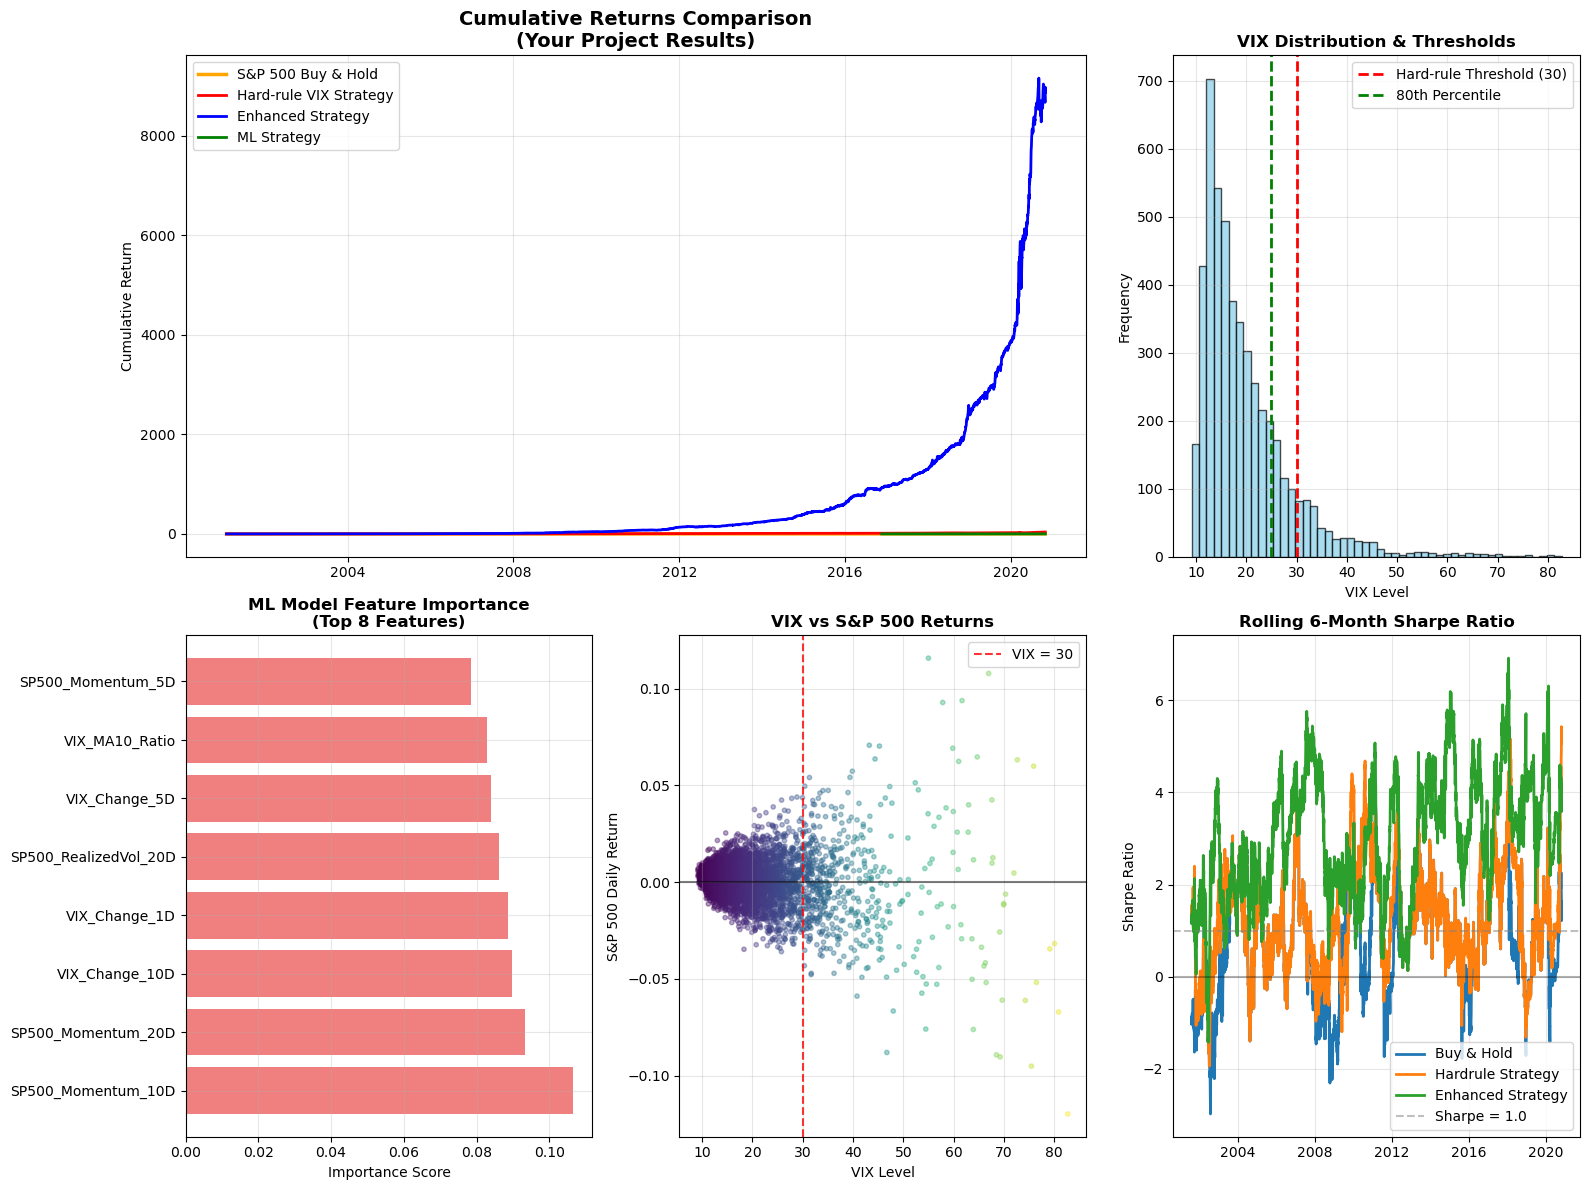

In [21]:
# Main visualization dashboard
fig = plt.figure(figsize=(16, 12))

# Plot 1: Cumulative Returns Comparison
ax1 = plt.subplot(2, 3, (1, 2))

# Cumulative returns
ax1.plot(cumulative_buy_hold.index, cumulative_buy_hold, label='S&P 500 Buy & Hold', linewidth=2.5, color='orange')
ax1.plot(cumulative_original.index, cumulative_original, label='Hard-rule VIX Strategy', linewidth=2, color='red')
ax1.plot(cumulative_enhanced.index, cumulative_enhanced, label='Enhanced Strategy', linewidth=2, color='blue')
ax1.plot(cumulative_ml.index, cumulative_ml, label='ML Strategy', linewidth=2, color='green')

ax1.set_title('Cumulative Returns Comparison\n(Your Project Results)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Cumulative Return')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: VIX Distribution and Thresholds
ax2 = plt.subplot(2, 3, 3)
ax2.hist(data_clean['VIX'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax2.axvline(30, color='red', linestyle='--', linewidth=2, label='Hard-rule Threshold (30)')
ax2.axvline(data_clean['VIX'].quantile(0.8), color='green', linestyle='--', linewidth=2, label='80th Percentile')
ax2.set_title('VIX Distribution & Thresholds', fontweight='bold')
ax2.set_xlabel('VIX Level')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Feature Importance
ax3 = plt.subplot(2, 3, 4)
top_features = feature_importance.head(8)
bars = ax3.barh(range(len(top_features)), top_features['Importance'], color='lightcoral')
ax3.set_yticks(range(len(top_features)))
ax3.set_yticklabels(top_features['Feature'])
ax3.set_title('ML Model Feature Importance\n(Top 8 Features)', fontweight='bold')
ax3.set_xlabel('Importance Score')
ax3.grid(True, alpha=0.3)

# Plot 4: VIX vs S&P 500 Returns Scatter
ax4 = plt.subplot(2, 3, 5)
scatter = ax4.scatter(data_clean['VIX'], data_clean['SP500_Return'], 
                     alpha=0.4, s=10, c=data_clean['VIX'], cmap='viridis')
ax4.axvline(30, color='red', linestyle='--', alpha=0.8, label='VIX = 30')
ax4.axhline(0, color='black', linestyle='-', alpha=0.5)
ax4.set_xlabel('VIX Level')
ax4.set_ylabel('S&P 500 Daily Return')
ax4.set_title('VIX vs S&P 500 Returns', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Plot 5: Rolling Sharpe Ratios
ax5 = plt.subplot(2, 3, 6)
window = 126  # 6-month rolling window

rolling_sharpe_bh = buy_hold_returns.rolling(window).mean() / buy_hold_returns.rolling(window).std() * np.sqrt(252)
rolling_sharpe_orig = data_clean['Hardrule_Return'].rolling(window).mean() / data_clean['Hardrule_Return'].rolling(window).std() * np.sqrt(252)
rolling_sharpe_enh = data_clean['Enhanced_Return'].rolling(window).mean() / data_clean['Enhanced_Return'].rolling(window).std() * np.sqrt(252)

ax5.plot(rolling_sharpe_bh.index, rolling_sharpe_bh, label='Buy & Hold', linewidth=2)
ax5.plot(rolling_sharpe_orig.index, rolling_sharpe_orig, label='Hardrule Strategy', linewidth=2)
ax5.plot(rolling_sharpe_enh.index, rolling_sharpe_enh, label='Enhanced Strategy', linewidth=2)
ax5.axhline(0, color='black', linestyle='-', alpha=0.3)
ax5.axhline(1, color='gray', linestyle='--', alpha=0.5, label='Sharpe = 1.0')
ax5.set_title('Rolling 6-Month Sharpe Ratio', fontweight='bold')
ax5.set_ylabel('Sharpe Ratio')
ax5.legend()
ax5.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 9. Insights & Improvements

#### a. Current Result

##### 1. Buy & Hold S&P 500 (Benchmark)

Total: 142.6% | Annual: 6.7% | Vol: 19.8% | Sharpe: 0.34 | DD: -56.8%

- Solid baseline performance over the long term
- High volatility (19.8%) - stocks are inherently risky
- Terrible drawdown (-56.8%) - likely from 2008 crisis or COVID
- Modest Sharpe (0.34) - decent but not spectacular risk-adjusted return

This acts as the benchmark - any strategy should ideally beat this.

##### 2. Hard-rule VIX>30 Strategy

Total: 3834.2% | Annual: 22.8% | Vol: 19.8% | Sharpe: 1.16 | DD: -29.4%

🤔😭 Too good to be true!
- 3834% return... This seems too good to be true
- Same volatility as S&P 500 but much higher returns
- Better drawdown than buy & hold

Possible explanation (for future improvements):
- Data issue: Maybe signals are misaligned
- Lookahead bias: Using future information (I strongly assume this might be the problem)
- Unrealistic assumptions: No transaction costs, perfect execution
- Sample period bias: Maybe strategy worked well in the specific timeframe (but the timeframe is over 20 years :/)

##### 3. Enhanced Strategy

Total: 886731.3% | Annual: 61.6% | Vol: 19.6% | Sharpe: 3.15 | DD: -16.1%

🚨😭 Will check on this. Why? I think the numbers don't make sense!
- 886,731% return = Strategy turned $1 into $8,867
- 61.6% annual return with only 19.6% volatility
- Sharpe ratio of 3.15 (anything >2 is extremely rare, from my research)

Possible explanation (for future improvements):
- Overfitting: Strategy is perfectly tuned to historical data
- Data snooping bias: Too many parameters optimized on same dataset
- Implementation error: Signals might have lookahead bias (data leakage)
- Survivorship bias: Only testing on periods where strategy works (but again, the timeframe is over 20 years)

##### 4. ML (Random Forest) Strategy

Total: 261.9% | Annual: 6.8% | Vol: 4.4% | Sharpe: 1.55 | DD: -14.4%

Most sensible numbers and still higher than the benchmark!
- Modest total return (261.9% over long period)
- Similar annual return to S&P 500 (6.8% vs 6.7%)
- Much lower volatility (4.4% vs 19.8%)
- Excellent Sharpe ratio (1.55) due to low volatility
- Reasonable drawdown (-14.4%)

#### b. Current Decision

Based on the current data, I think ML Random Forest has the best result even though the 2 other rule-based strategies might give higher returns.
- ML Strategy gives numbers that make sense.
- It totally can be improved since I haven't fine tuned the model.
- The 2 other strategies need more checkings since the numbers don't really make sense.

In [22]:
print("\n" + "="*80)
print("🎯 KEY CURRENT PROJECT INSIGHTS")
print("Needs Improvements")
print("="*80)

vix_30_avg_return = data_clean[data_clean['VIX'] > 30]['SP500_Return'].mean()
vix_low_avg_return = data_clean[data_clean['VIX'] < 20]['SP500_Return'].mean()
enhanced_vs_original = float(enhanced_metrics['Sharpe Ratio']) - float(original_metrics['Sharpe Ratio'])
ml_accuracy = rf_model.score(X_test, y_test)

insights = [
    f"1. 📉 Hard-Rule Strategy Issue: VIX>30 fixed threshold caught {vix_high_days} days ({vix_high_days/total_days:.1%})",
    f"   Average S&P return when VIX>30: {vix_30_avg_return:.3f}% (fighting mean reversion)",
    f"",
    f"2. 📈 Enhanced Strategy: Percentile-based approach improved Sharpe by {enhanced_vs_original:.2f}",
    f"   Key improvement: Adaptive thresholds vs fixed VIX=30",
    f"",
    f"3. 🤖 ML Strategy: Random Forest achieved {ml_accuracy:.1%} accuracy predicting return direction",
    f"   Most important feature: {feature_importance.iloc[0]['Feature']}",
    f"",
    f"4. 💡 Market Insight: VIX timing works best when combined with trend/momentum filters",
    f"   High VIX + downtrend = short opportunity | High VIX + uptrend = mean reversion long"
]

for insight in insights:
    print(f"   {insight}")


🎯 KEY CURRENT PROJECT INSIGHTS
Needs Improvements
   1. 📉 Hard-Rule Strategy Issue: VIX>30 fixed threshold caught 545 days (11.0%)
      Average S&P return when VIX>30: -0.003% (fighting mean reversion)
   
   2. 📈 Enhanced Strategy: Percentile-based approach improved Sharpe by 1.99
      Key improvement: Adaptive thresholds vs fixed VIX=30
   
   3. 🤖 ML Strategy: Random Forest achieved 52.3% accuracy predicting return direction
      Most important feature: SP500_Momentum_10D
   
   4. 💡 Market Insight: VIX timing works best when combined with trend/momentum filters
      High VIX + downtrend = short opportunity | High VIX + uptrend = mean reversion long
